<a href="https://colab.research.google.com/github/syedsaifhasan/text-analysis/blob/main/Supervised%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In this step, we imported and installed all the necessary libraries needed to perform Multi-Label Document Classification.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')
nltk.download('reuters')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [ ]:
import os
import sys
import numpy as np

from tensorflow import keras

from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, GRU, MaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Input
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import average
from nltk.corpus import reuters
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import matplotlib.pyplot as plt

from keras import backend as K

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Initializing Parameters

We initialied and defined the parameters of our document classifier in this step.

In [ ]:
MAX_SEQUENCE_LENGTH = 1335
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 300

labels = reuters.categories()
n_classes = len(labels)
mlb = MultiLabelBinarizer(labels)

# Preparing the Dataset

We created three subsets which are training, testing and validation sets. The validation set was prepared by splitting the training set in 9:1 ratio.

In [ ]:
# LOAD DATASET

# Function to load dataset
def load_set(set_name, multi_label):
  # Load Training Data
  data_ids =  list(filter(lambda x: x.startswith(set_name), reuters.fileids()))
  data = []
  labels = []
  count = 0
  for doc_id in data_ids:
    if (multi_label == True):
      data.append(reuters.raw(doc_id))
      labels.append(reuters.categories(doc_id))
    else:
      if (len(reuters.categories(doc_id)) == 1):
        data.append(reuters.raw(doc_id))
        labels.append(reuters.categories(doc_id))
  return data, labels

# Load Training Set and Labels
train_data, train_labels = load_set('training/', True)

# Load Validation Set and Labels
split = round(len(train_data)*0.90)

validation_data = train_data[split+1:]
validation_labels = train_labels[split+1:]

train_data = train_data[:split]
train_labels = train_labels[:split]

# Load Testing Set and Labels
test_data, test_labels = load_set('test/', False)

print ('Dataset Loaded...')
print ('Training Data: {} Samples, {} Labels'.format(len(train_data), len(train_labels)))
print ('Validation Data: {} Samples, {} Labels'.format(len(validation_data), len(validation_labels)))
print ('Testing Data: {} Samples, {} Labels'.format(len(test_data), len(test_labels)))

Dataset Loaded...
Training Data: 6992 Samples, 6992 Labels
Validation Data: 776 Samples, 776 Labels
Testing Data: 2583 Samples, 2583 Labels


The subsets were transformed into their respective encodings and their dictionaries were also created.

In [ ]:
# ENCODE TEXT AND LABELS
print('Encoding Data....')

def encode(data, labels):
  # Encode Text
  tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(data)
  sequences = tokenizer.texts_to_sequences(data)
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
  # Encode Labels
  labels = mlb.fit_transform(labels)
  # Create Dictsizeionary
  dictionary = tokenizer.word_index
  return data, labels, dictionary

# FETCH DATA, LABELS, DICTIONARIES
train_data, train_labels, train_dictionary = encode(train_data, train_labels)
validation_data, validation_labels, validation_dictionary = encode(validation_data, validation_labels)
test_data, test_labels, test_dictionary = encode(test_data, test_labels)

actual = test_labels

print ("Data Encoded...\n")

print ("Dictionaries Loaded...")
print ('Training Dictionary: {} Words'.format(len(train_dictionary)))
print ('Validation Dictionary: {} Words'.format(len(validation_dictionary)))
print ('Testing Dictionary: {} Words'.format(len(test_dictionary)))

Encoding Data....
Data Encoded...

Dictionaries Loaded...
Training Dictionary: 26351 Words
Validation Dictionary: 8918 Words
Testing Dictionary: 15759 Words


# Creating Embedding Matrix

We loaded both the word embedding models and created their large emdbedding matrices of all the words present in the model.

In [ ]:
print('Preparing embedding matrix....\n')

print ('Loading the pretrained models...')

pretrained_model_paths = {'fasttext':'wiki-news-300d-1M-subword.vec', 'glove': 'glove.6B.300d.txt', 'word2Vec': 'GoogleNews-vectors-negative300.txt'}
embeddings_indexes = {}

for model, path in pretrained_model_paths.items():
  embeddings_index = {}
  print ("Loading {} model's pretrained embeddings...".format(model))
  with open('/content/drive/My Drive/word_embedding_model/' + path) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, 'f', sep=' ')
          embeddings_index[word] = coefs
  embeddings_indexes[model] = embeddings_index
  print('Found {} word vectors in this model.'.format(len(embeddings_index)))

Preparing embedding matrix....

Loading the pretrained models...
Loading fasttext model's pretrained embeddings...
Found 999995 word vectors in this model.
Loading glove model's pretrained embeddings...
Found 400000 word vectors in this model.
Loading word2Vec model's pretrained embeddings...
Found 3000000 word vectors in this model.


In this process, we prepared two embedding matrices for each model with respect to the training data. 

To do this, we first initialized a 2D matrix of size (Number of words, word vector size) with zeros and updated each row with the word vectors fetched from the large embedding matrix. The process is repeated for both the models.

In [ ]:
num_words = min(MAX_NUM_WORDS, len(train_dictionary) + 1)
embedding_matrices = {}

for model, embedding_index in embeddings_indexes.items():
  print ("Preparing {} model's embedding matrix...".format(model))
  embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
  for word, i in train_dictionary.items():
      if i >= MAX_NUM_WORDS:
          continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  print ('Embedding Matrix Created of size', embedding_matrix.shape)
  embedding_matrices[model] = embedding_matrix

Preparing fasttext model's embedding matrix...
Embedding Matrix Created of size (10000, 300)
Preparing glove model's embedding matrix...
Embedding Matrix Created of size (10000, 300)
Preparing word2Vec model's embedding matrix...
Embedding Matrix Created of size (10000, 300)


# Creating the Neural Network

In this step we created the evaluation functions for multi-label classification.

In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def accuracy(y_true, y_pred):
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    accuracy = (true_positives) / (possible_positives + predicted_positives + K.epsilon())
    return accuracy

def f1(y_true, y_pred):
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = 2 * ((p * r) / (p + r))
    return f1

We created an ensemble model using two branches of neural networks. The structure of the neural network is included in the seminar paper.

In [ ]:
print ('Building Model...')

def get_model(embedding_model):
  print (embedding_model.shape)
  embedding_layer = Embedding(num_words,
                              EMBEDDING_DIM,
                              embeddings_initializer=Constant(embedding_model),
                              input_length=1335,
                              trainable=False)
  model = Sequential()
  model.add(embedding_layer)
  model.add(Conv1D(filters=256, kernel_size=10, activation='relu'))
  model.add(MaxPooling1D(pool_size=4))
  model.add(LSTM(256, recurrent_dropout=0.5))
  model.add(Dense(n_classes, activation='sigmoid'))
  print(model.summary())
  return model

Building Model...


# FastText Evaluation

## Build Model

In [ ]:
embedding_model = 'fasttext'
model = get_model(embedding_matrices[embedding_model])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[accuracy, precision, recall, f1])

(10000, 300)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1335, 300)         3000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1326, 256)         768256    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 331, 256)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_20 (Dense)             (None, 90)                23130     
Total params: 4,316,698
Trainable params: 1,316,698
Non-trainable params: 3,000,000
_________________________________________________________________
None


## Training the neural network

We trained the neural network in 4 epochs.

In [ ]:
print('Training Started...\n')
history  = model.fit(train_data, train_labels,
          batch_size=128,
          epochs=20, shuffle=True,
          validation_data=(validation_data, validation_labels))

Training Started...

Epoch 1/20
55/55 [==============================] - 73s 1s/step - loss: 0.1102 - accuracy: 0.0147 - precision: 0.1219 - recall: 0.0349 - f1: nan - val_loss: 0.0461 - val_accuracy: 0.0917 - val_precision: 0.9098 - val_recall: 0.1033 - val_f1: 0.1835
Epoch 2/20
55/55 [==============================] - 73s 1s/step - loss: 0.0467 - accuracy: 0.1484 - precision: 0.9476 - recall: 0.1776 - f1: 0.2968 - val_loss: 0.0450 - val_accuracy: 0.1071 - val_precision: 0.9051 - val_recall: 0.1253 - val_f1: 0.2142
Epoch 3/20
55/55 [==============================] - 73s 1s/step - loss: 0.0439 - accuracy: 0.1909 - precision: 0.9635 - recall: 0.2395 - f1: 0.3818 - val_loss: 0.0446 - val_accuracy: 0.1274 - val_precision: 0.9139 - val_recall: 0.1514 - val_f1: 0.2548
Epoch 4/20
55/55 [==============================] - 67s 1s/step - loss: 0.0422 - accuracy: 0.2011 - precision: 0.9600 - recall: 0.2556 - f1: 0.4022 - val_loss: 0.0455 - val_accuracy: 0.1197 - val_precision: 0.8044 - val_recall

## Evaluating the model

We evaluated the model in this step.

In [ ]:
print ('Evaluating Model...')
score, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_data, test_labels,
                            batch_size=128)
# print('\nTest score:', score)
print('Test accuracy:', round(test_acc*100, 2))
print('Test precision:', round(test_precision*100, 2))
print('Test recall:', round(test_recall*100, 2))
print('Test F1:', round(test_f1*100, 2))

Evaluating Model...
21/21 [==============================] - 3s 138ms/step - loss: 0.0522 - accuracy: 0.1373 - precision: 0.4413 - recall: 0.1998 - f1: nan
Test accuracy: 13.73
Test precision: 44.13
Test recall: 19.98
Test F1: nan


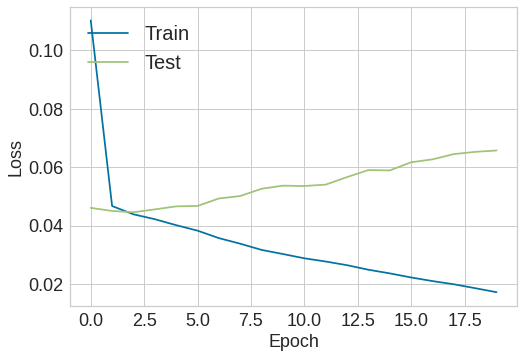

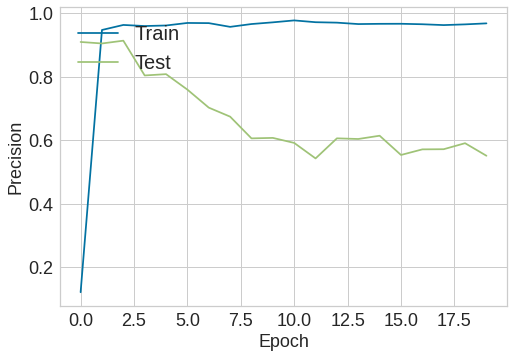

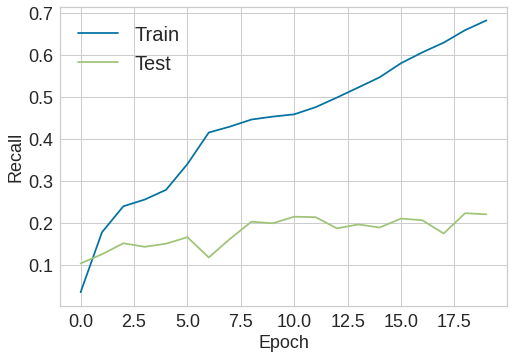

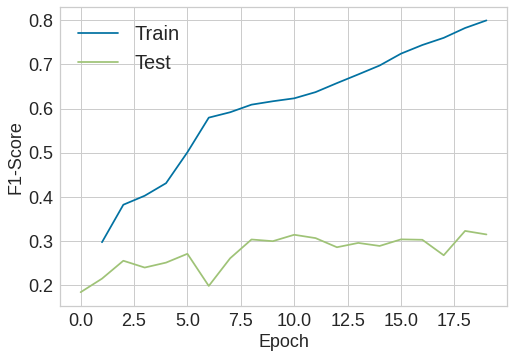

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation loss values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Recall', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation loss values
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

In [ ]:
print ("Macro Recall: ", np.mean(history.history['val_recall']))
# print ("Macro Accuracy: ", np.mean(history.history['val_accuracy_metric']))
print ("Macro Precision: ", np.mean(history.history['val_precision']))
print ("Macro F1: ", np.mean(history.history['val_f1']))

Macro Recall:  0.17782663218677044
Macro Precision:  0.6747324079275131
Macro F1:  0.2736092694103718


# GloVe Evaluation

## Build Model

In [ ]:
embedding_model = 'glove'
model = get_model(embedding_matrices[embedding_model])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[accuracy, precision, recall, f1])

(10000, 300)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1335, 300)         3000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1326, 256)         768256    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 331, 256)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_21 (Dense)             (None, 90)                23130     
Total params: 4,316,698
Trainable params: 1,316,698
Non-trainable params: 3,000,000
_________________________________________________________________
None


## Training the neural network

We trained the neural network in 4 epochs.

In [ ]:
print('Training Started...\n')
history  = model.fit(train_data, train_labels,
          batch_size=128,
          epochs=20, shuffle=True,
          validation_data=(validation_data, validation_labels))

Training Started...

Epoch 1/20
55/55 [==============================] - 70s 1s/step - loss: 0.1147 - accuracy: 0.0072 - precision: 0.0256 - recall: 0.0357 - f1: nan - val_loss: 0.0469 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: nan
Epoch 2/20
55/55 [==============================] - 65s 1s/step - loss: 0.0478 - accuracy: 0.0886 - precision: 0.8884 - recall: 0.1038 - f1: nan - val_loss: 0.0454 - val_accuracy: 0.0978 - val_precision: 0.9121 - val_recall: 0.1139 - val_f1: 0.1957
Epoch 3/20
55/55 [==============================] - 65s 1s/step - loss: 0.0450 - accuracy: 0.1734 - precision: 0.9397 - recall: 0.2143 - f1: 0.3468 - val_loss: 0.0452 - val_accuracy: 0.1084 - val_precision: 0.9330 - val_recall: 0.1268 - val_f1: 0.2168
Epoch 4/20
55/55 [==============================] - 71s 1s/step - loss: 0.0427 - accuracy: 0.1966 - precision: 0.9543 - recall: 0.2490 - f1: 0.3931 - val_loss: 0.0450 - val_accuracy: 0.1654 - val_precision: 0.6549 - val_

## Evaluating the model

We evaluated the model in this step.

In [ ]:
print ('Evaluating Model...')
score, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_data, test_labels,
                            batch_size=128)
# print('\nTest score:', score)
print('Test accuracy:', round(test_acc*100, 2))
print('Test precision:', round(test_precision*100, 2))
print('Test recall:', round(test_recall*100, 2))
print('Test F1:', round(test_f1*100, 2))

Evaluating Model...
21/21 [==============================] - 2s 118ms/step - loss: 0.0528 - accuracy: 0.1375 - precision: 0.4670 - recall: 0.1957 - f1: nan
Test accuracy: 13.75
Test precision: 46.7
Test recall: 19.57
Test F1: nan


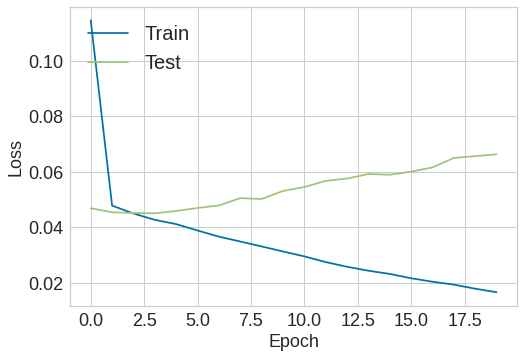

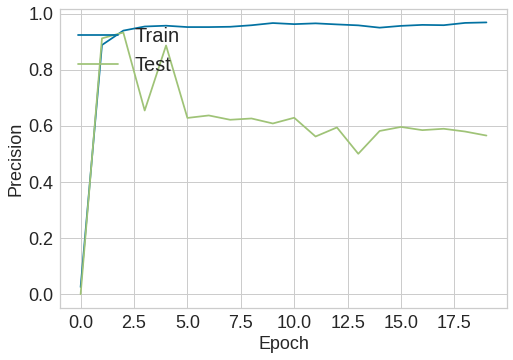

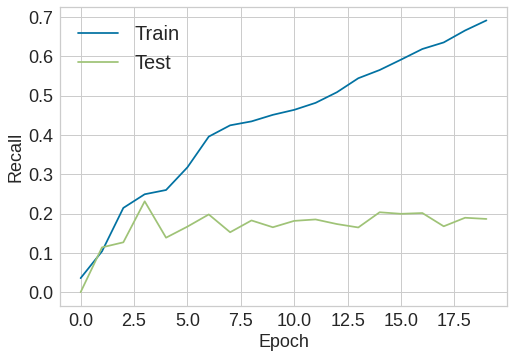

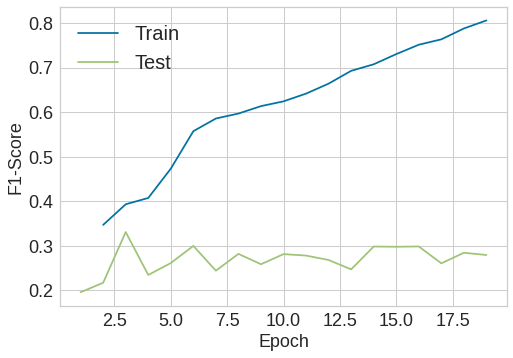

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation loss values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Recall', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation loss values
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

In [ ]:
print ("Macro Recall: ", np.mean(history.history['val_recall']))
# print ("Macro Accuracy: ", np.mean(history.history['val_accuracy_metric']))
print ("Macro Precision: ", np.mean(history.history['val_precision']))
print ("Macro F1: ", np.mean(history.history['val_f1']))

Macro Recall:  0.16630983352661133
Macro Precision:  0.6146981835365295
Macro F1:  nan


# Word2Vec Evaluation

## Build Model

In [ ]:
embedding_model = 'word2Vec'
model = get_model(embedding_matrices[embedding_model])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[accuracy, precision, recall, f1])

(10000, 300)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 1335, 300)         3000000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1326, 256)         768256    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 331, 256)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_22 (Dense)             (None, 90)                23130     
Total params: 4,316,698
Trainable params: 1,316,698
Non-trainable params: 3,000,000
_________________________________________________________________
None


## Training the neural network

We trained the neural network in 4 epochs.

In [ ]:
print('Training Started...\n')
history  = model.fit(train_data, train_labels,
          batch_size=128,
          epochs=20, shuffle=True,
          validation_data=(validation_data, validation_labels))

Training Started...

Epoch 1/20
55/55 [==============================] - 66s 1s/step - loss: 0.1115 - accuracy: 0.0197 - precision: 0.0567 - recall: 0.0660 - f1: nan - val_loss: 0.0466 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: nan
Epoch 2/20
55/55 [==============================] - 72s 1s/step - loss: 0.0479 - accuracy: 0.0830 - precision: 0.6331 - recall: 0.0970 - f1: nan - val_loss: 0.0453 - val_accuracy: 0.0965 - val_precision: 0.9327 - val_recall: 0.1121 - val_f1: 0.1930
Epoch 3/20
55/55 [==============================] - 72s 1s/step - loss: 0.0452 - accuracy: 0.1732 - precision: 0.9491 - recall: 0.2129 - f1: 0.3465 - val_loss: 0.0450 - val_accuracy: 0.1146 - val_precision: 0.8032 - val_recall: 0.1365 - val_f1: 0.2293
Epoch 4/20
55/55 [==============================] - 72s 1s/step - loss: 0.0430 - accuracy: 0.1956 - precision: 0.9569 - recall: 0.2468 - f1: 0.3912 - val_loss: 0.0458 - val_accuracy: 0.1224 - val_precision: 0.6929 - val_

## Evaluating the model

We evaluated the model in this step.

In [ ]:
print ('Evaluating Model...')
score, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_data, test_labels,
                            batch_size=128)
# print('\nTest score:', score)
print('Test accuracy:', round(test_acc*100, 2))
print('Test precision:', round(test_precision*100, 2))
print('Test recall:', round(test_recall*100, 2))
print('Test F1:', round(test_f1*100, 2))

Evaluating Model...
21/21 [==============================] - 3s 148ms/step - loss: 0.0541 - accuracy: 0.0930 - precision: 0.4348 - recall: 0.1190 - f1: nan
Test accuracy: 9.3
Test precision: 43.48
Test recall: 11.9
Test F1: nan


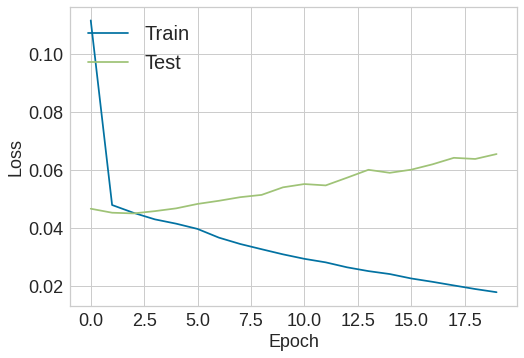

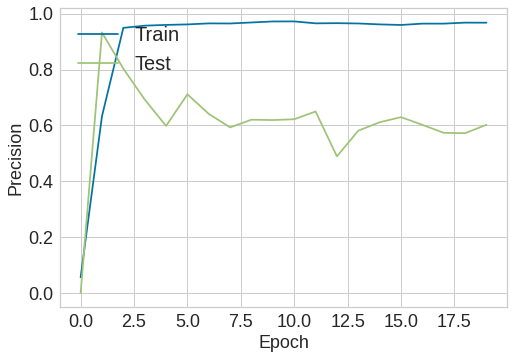

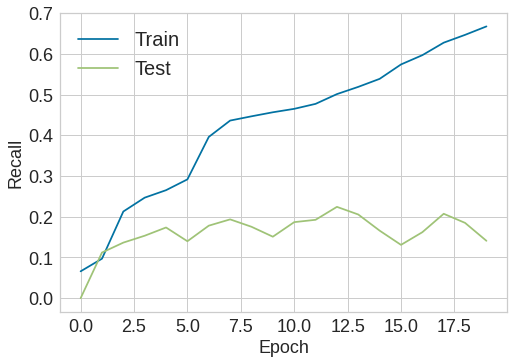

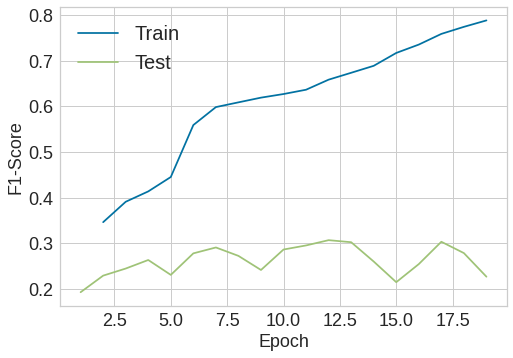

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation loss values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Recall', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation loss values
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

In [ ]:
print ("Macro Recall: ", np.mean(history.history['val_recall']))
# print ("Macro Accuracy: ", np.mean(history.history['val_accuracy_metric']))
print ("Macro Precision: ", np.mean(history.history['val_precision']))
print ("Macro F1: ", np.mean(history.history['val_f1']))

Macro Recall:  0.16071977131068707
Macro Precision:  0.6074023053050042
Macro F1:  nan
